In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights


class CUB200Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, apply_bg_removal=False):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform or self.default_transform()
        self.apply_bg_removal = apply_bg_removal

        # Load metadata
        self.data = self.load_metadata()

    def load_metadata(self):
        split_file = os.path.join(self.root_dir, f'{self.split}.txt')
        data = pd.read_csv(split_file, sep=' ', names=['filename', 'label'])
        data['filepath'] = data['filename'].apply(lambda x: os.path.join(self.root_dir, self.split, x))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.loc[idx, 'filepath']
        image = self.load_image(img_name)

        # Apply background removal and cropping if enabled
        if self.apply_bg_removal:
            image = remove_background_and_crop(image)

        # Apply transformations to convert the cropped image to a tensor
        image = self.transform(image)

        label = self.data.loc[idx, 'label']
        return image, label

    @staticmethod
    def load_image(image_path):
        try:
            return Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def default_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [ ]:
def remove_background_and_crop(image, model, device):
    # Preprocess image for DeepLabV3
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Get the output from DeepLabV3
    with torch.no_grad():
        output = model(input_image)['out']

    # Get the class with the highest probability for each pixel
    output = torch.argmax(output, dim=1).cpu().numpy()[0]

    # Assuming 0 is the background, get the bird class mask (all non-background)
    bird_mask = (output != 0)

    # Find the bounding box of the bird
    coords = np.argwhere(bird_mask)
    if coords.any():
        # Get the bounding box coordinates
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        # Resize the original image to (256, 256) for consistency
        image_resized = image.resize((256, 256))
        image_np = np.array(image_resized)

        # Crop the image based on the bounding box of the bird
        cropped_image = image_np[y_min:y_max, x_min:x_max]

        if cropped_image.size == 0:
            # If empty, return the original resized image
            return image.resize((256, 256))
        else:
            # Convert the cropped image back to PIL format
            return Image.fromarray(cropped_image)
    else:
        # If no bird is detected, return the original resized image
        return image.resize((256, 256))

In [ ]:
def preprocess_and_save_dataset(dataset, model, device, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    for idx in tqdm(range(len(dataset))):
        img_name = dataset.data.loc[idx, 'filename']
        img_path = dataset.data.loc[idx, 'filepath']

        # Load the original image
        original_image = dataset.load_image(img_path)
        if original_image is None:
            continue  # Skip if the image couldn't be loaded

        # Apply background removal and cropping
        processed_image = remove_background_and_crop(original_image, model, device)

        # Save the processed image
        processed_image_path = os.path.join(save_dir, img_name)
        processed_image.save(processed_image_path)

In [ ]:
def show_random_samples_with_original(dataset, root_dir, model, device, num_samples=10):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Generate random indices
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(random_indices):
        img_name = dataset.data.loc[idx, 'filepath']
        original_image = dataset.load_image(img_name)
        if original_image is None:
            continue

        cropped_image = remove_background_and_crop(original_image, model, device)

        # Resize for display
        original_image = transforms.Resize((224, 224))(original_image)
        cropped_image = transforms.Resize((224, 224))(cropped_image)

        # Display original image in the top row
        axes[0, i].imshow(original_image)
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display cropped image in the bottom row
        axes[1, i].imshow(cropped_image)
        axes[1, i].set_title('Cropped')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

100%|██████████| 4829/4829 [33:15<00:00,  2.42it/s]


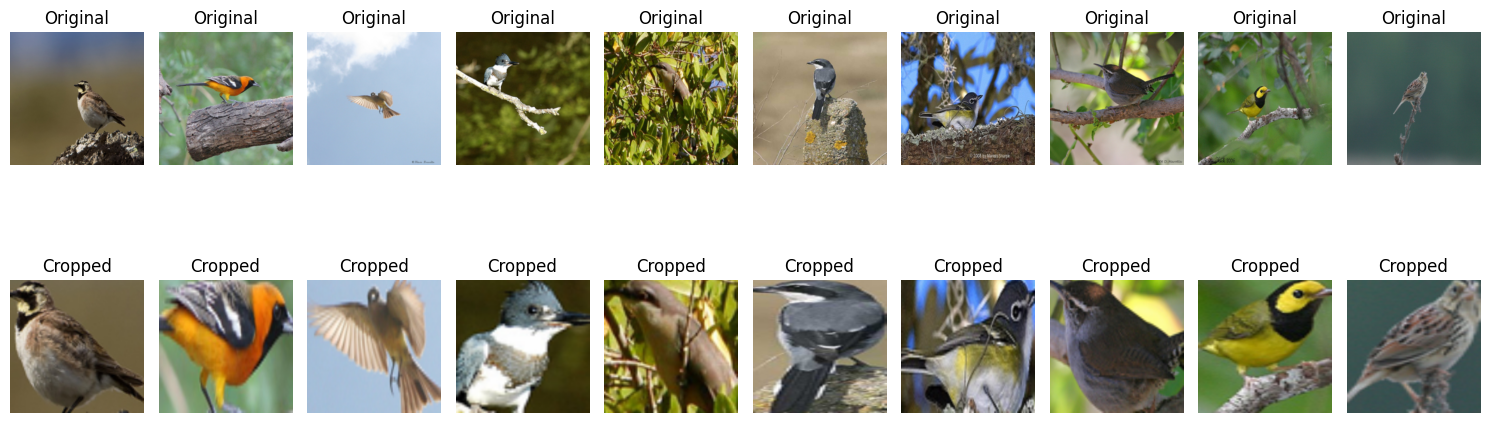

In [7]:
def main():
    root_dir = 'drive/MyDrive/COS30082'
    train_save_dir = 'drive/MyDrive/COS30082_preprocessed/train'
    test_save_dir = 'drive/MyDrive/COS30082_preprocessed/test'

    # Load pre-trained DeepLabV3 model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    deeplab_model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
    deeplab_model.to(device)
    deeplab_model.eval()

    # Initialize train and test datasets with background removal enabled
    train_dataset = CUB200Dataset(root_dir=root_dir, split='train', apply_bg_removal=True, model=deeplab_model, device=device)
    test_dataset = CUB200Dataset(root_dir=root_dir, split='test', apply_bg_removal=True, model=deeplab_model, device=device)

    # Preprocess and save train dataset
    print("Processing train dataset...")
    preprocess_and_save_dataset(train_dataset, train_save_dir)

    # Preprocess and save test dataset
    print("Processing test dataset...")
    preprocess_and_save_dataset(test_dataset, test_save_dir)

    # Optionally: Display random samples from the train dataset
    show_random_samples_with_original(train_dataset, num_samples=10)

if __name__ == "__main__":
    main()
